Energy with dietary fibre, equated \n(kJ)        9.92
Calcium (Ca) \n(mg)                              9.92
Energy, without dietary fibre, equated \n(kJ)    9.92
Potassium (K) \n(mg)                             9.92
Moisture (water) \n(g)                           9.92
Nitrogen \n(g)                                   9.84
Magnesium (Mg) \n(mg)                            9.84
Sodium (Na) \n(mg)                               9.84
Phosphorus (P) \n(mg)                            9.84
Zinc (Zn) \n(mg)                                 9.84
Protein \n(g)                                    9.84
Ash \n(g)                                        9.84
Iron (Fe) \n(mg)                                 9.60
Niacin derived from tryptophan \n(mg)            9.60
Niacin derived equivalents \n(mg)                9.60
Tryptophan \n(mg)                                9.60
Fat, total \n(g)                                 9.20
Thiamin (B1) \n(mg)                              9.20
Riboflavin (B2) \n(mg)      

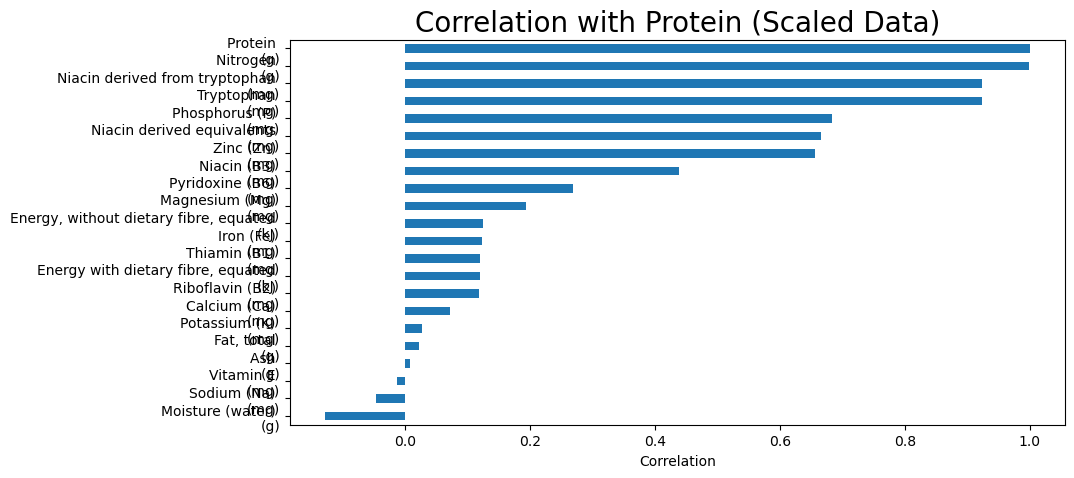

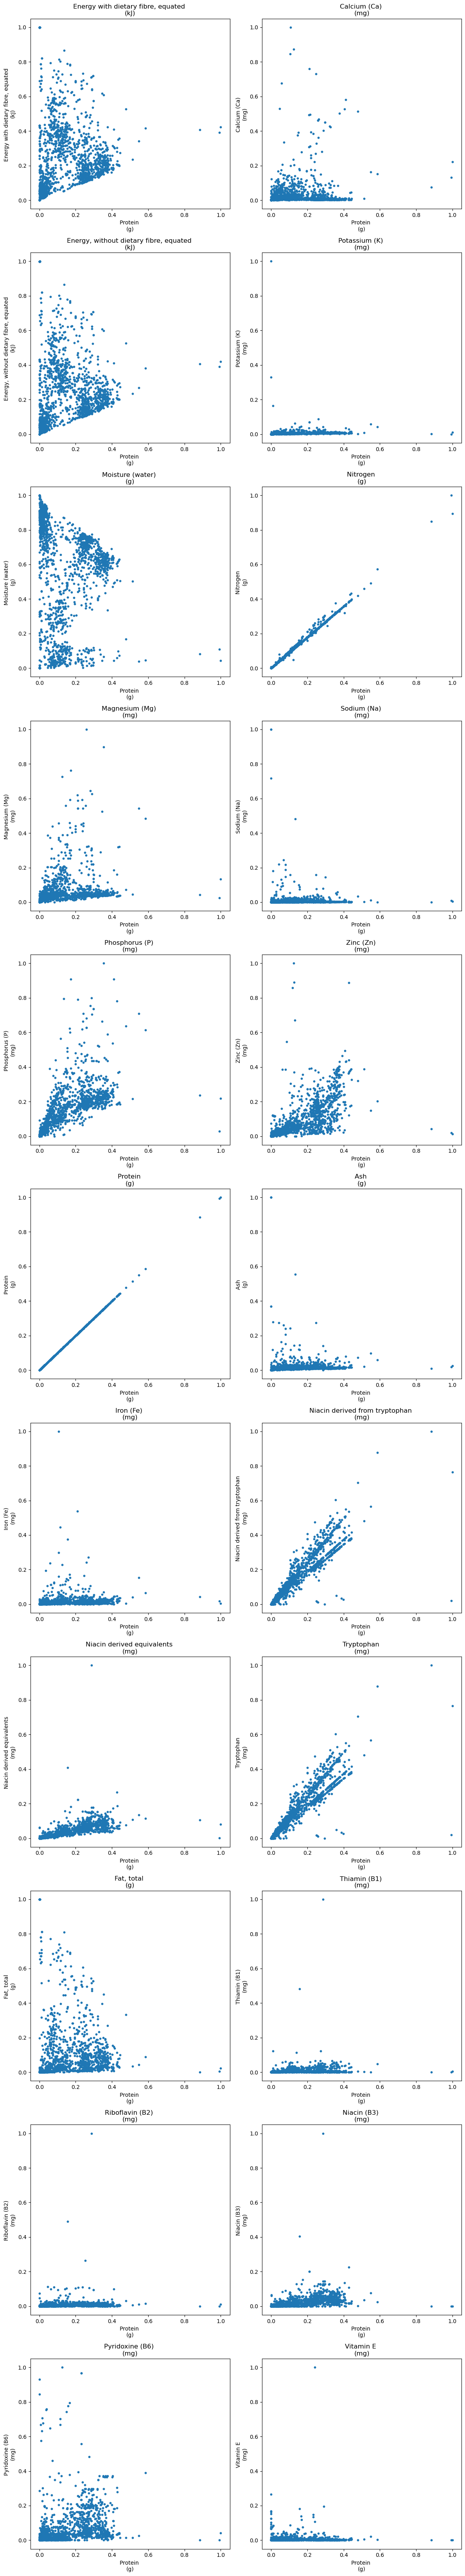

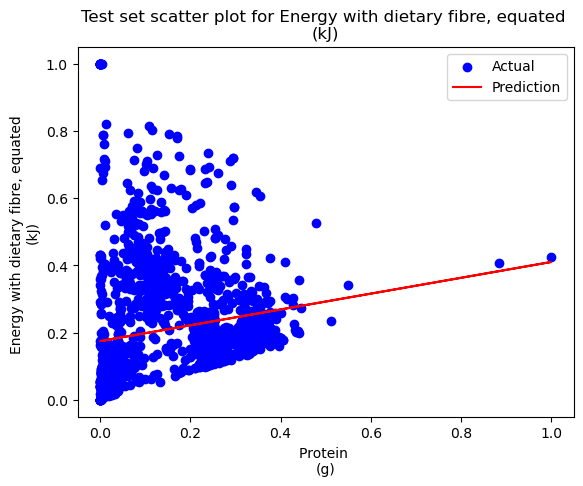

MSE of the linear model trained only by the feature: Protein (g): 0.03749278091732279


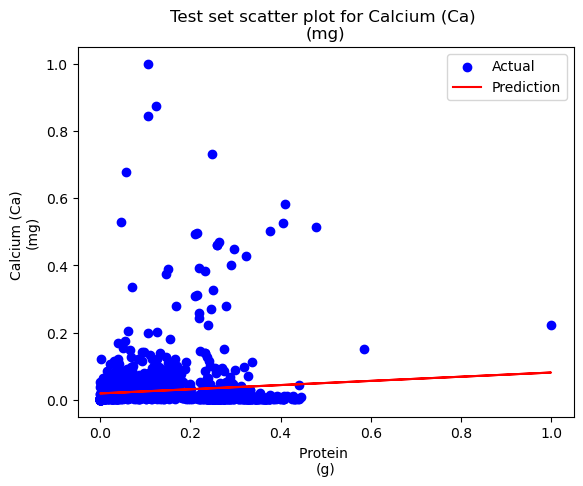

MSE of the linear model trained only by the feature: Protein (g): 0.0064722455308452685


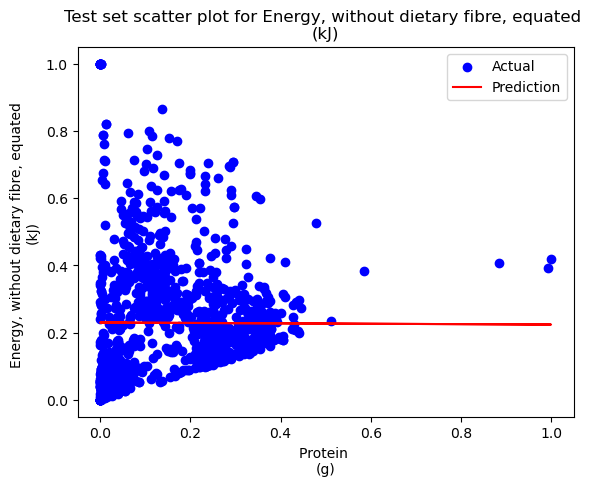

MSE of the linear model trained only by the feature: Protein (g): 0.03376693218458563


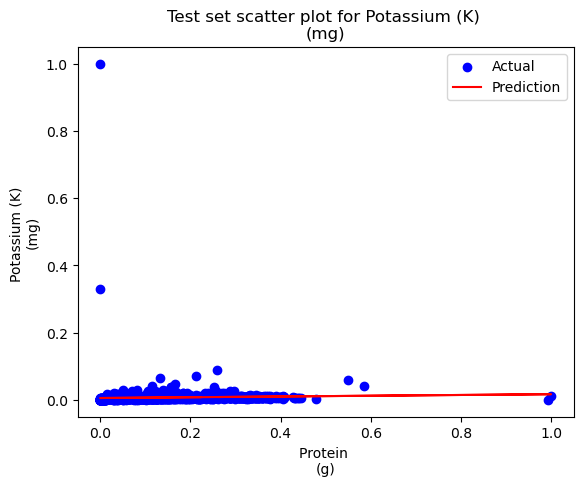

MSE of the linear model trained only by the feature: Protein (g): 0.0008805206646333148


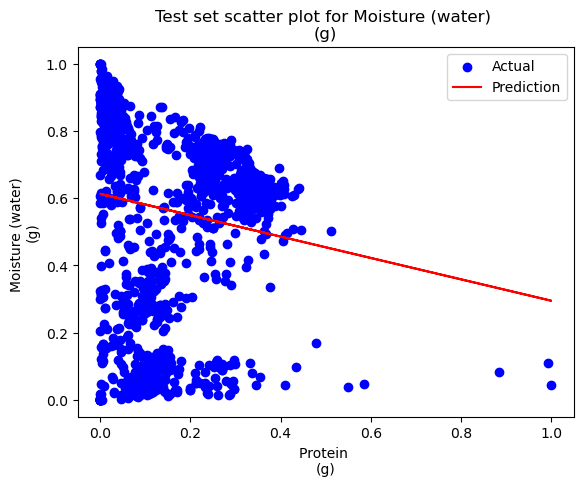

MSE of the linear model trained only by the feature: Protein (g): 0.08392494645574418


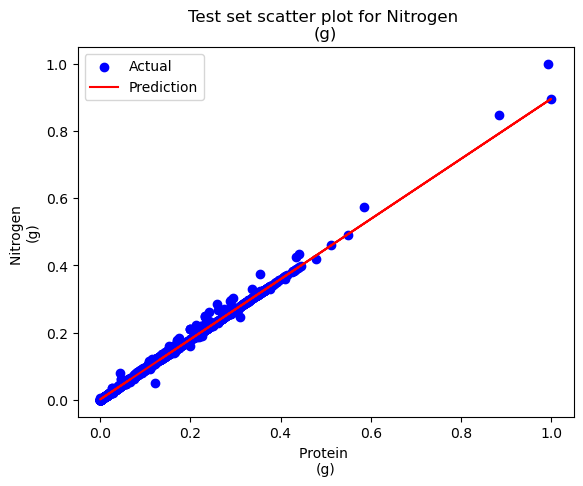

MSE of the linear model trained only by the feature: Protein (g): 5.094184622084846e-05


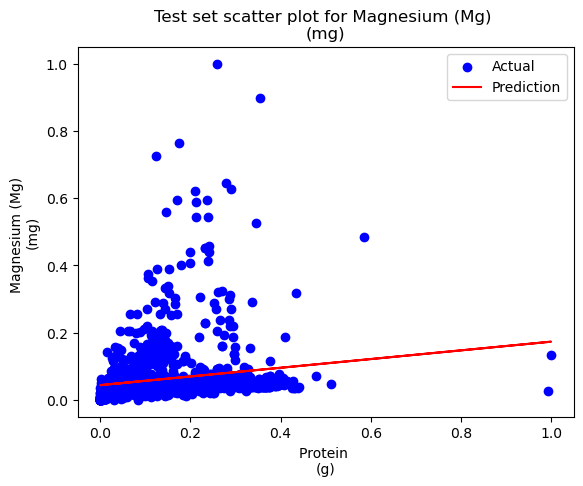

MSE of the linear model trained only by the feature: Protein (g): 0.007871011629830837


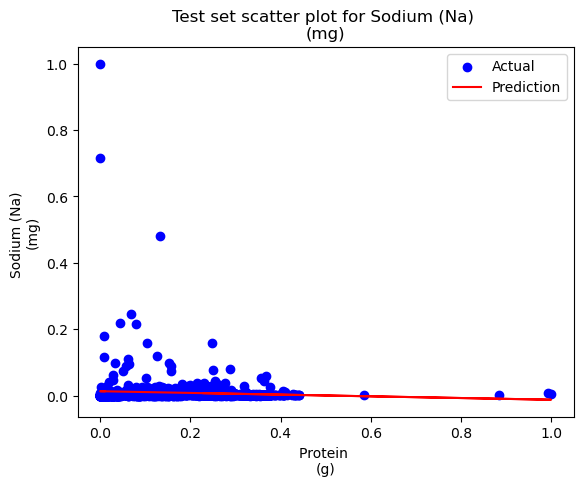

MSE of the linear model trained only by the feature: Protein (g): 0.0016307550191558809


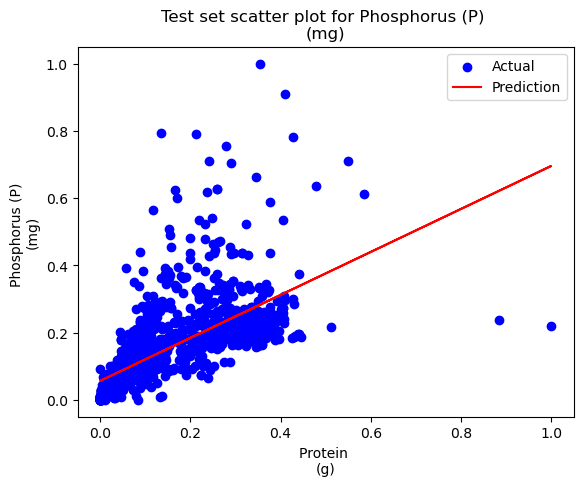

MSE of the linear model trained only by the feature: Protein (g): 0.008499962752476786


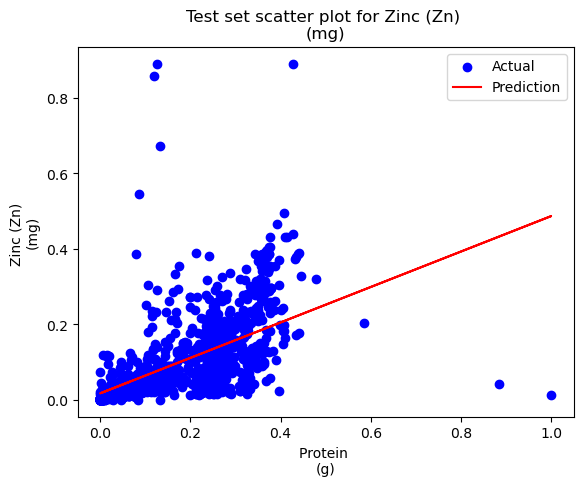

MSE of the linear model trained only by the feature: Protein (g): 0.006214222898509252


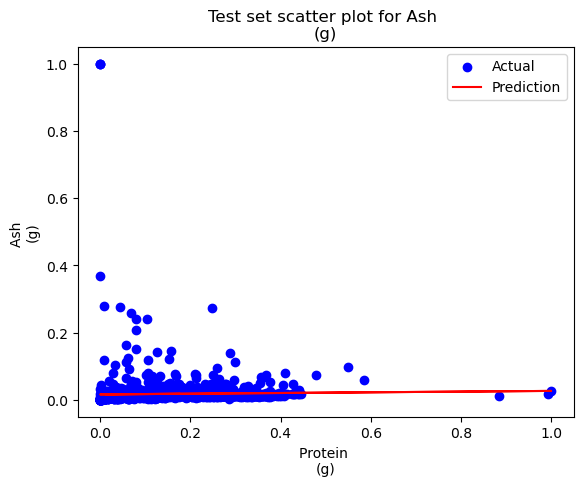

MSE of the linear model trained only by the feature: Protein (g): 0.0029246724467198084


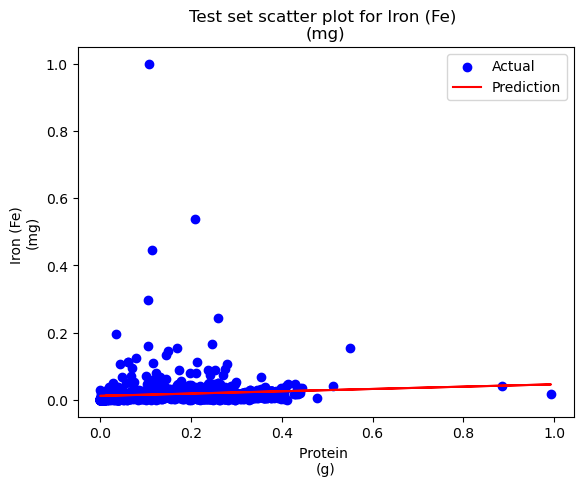

MSE of the linear model trained only by the feature: Protein (g): 0.0015273329518825697


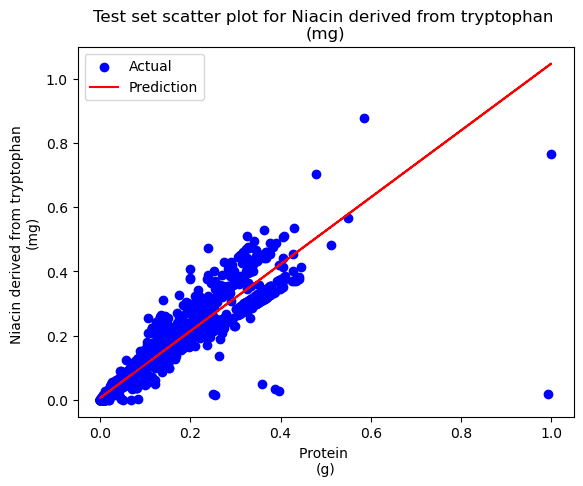

MSE of the linear model trained only by the feature: Protein (g): 0.00312081772918281


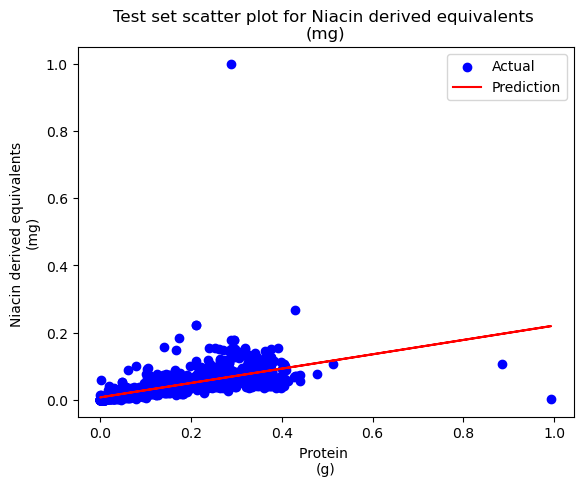

MSE of the linear model trained only by the feature: Protein (g): 0.0012058233540625455


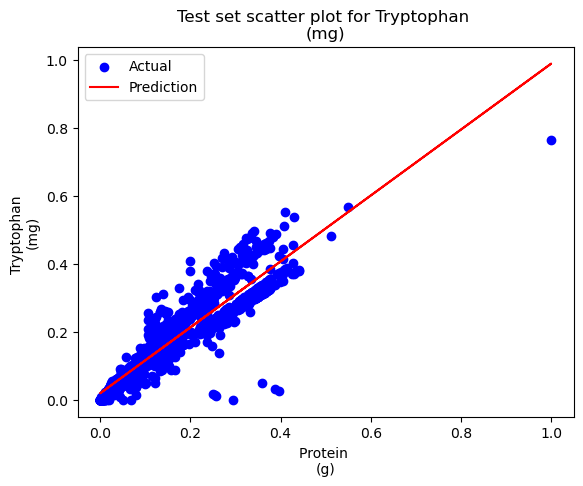

MSE of the linear model trained only by the feature: Protein (g): 0.002308922262573419


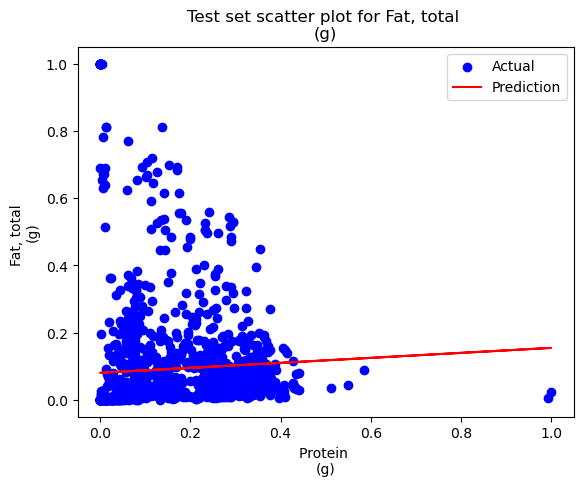

MSE of the linear model trained only by the feature: Protein (g): 0.02980477798623312


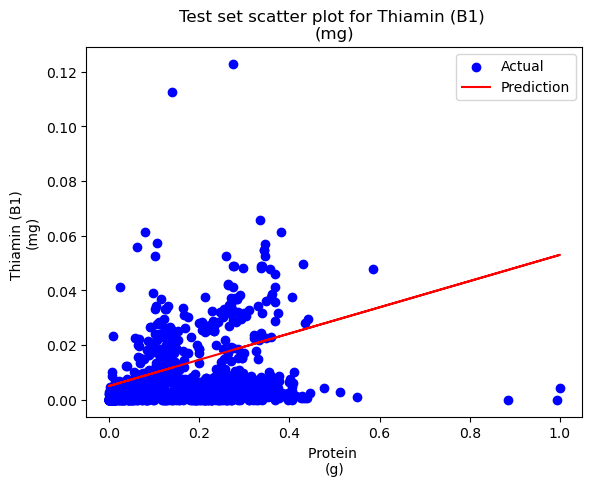

MSE of the linear model trained only by the feature: Protein (g): 0.00015630744879565294


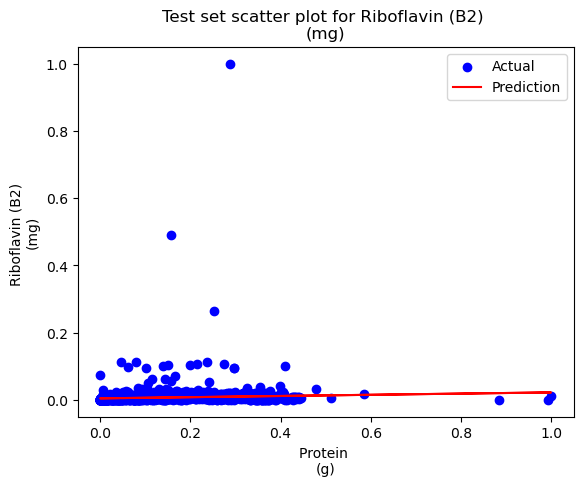

MSE of the linear model trained only by the feature: Protein (g): 0.0011334837424864627


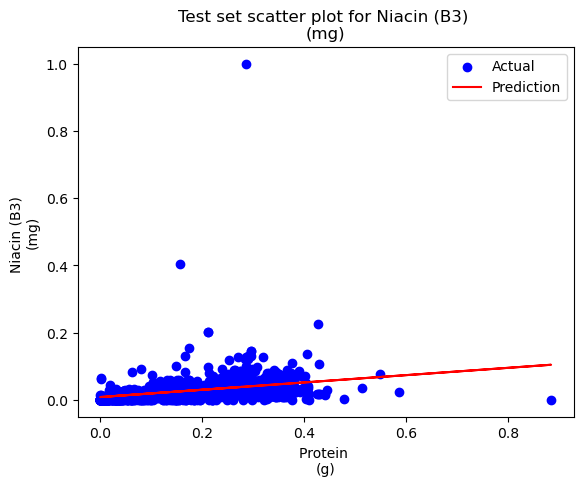

MSE of the linear model trained only by the feature: Protein (g): 0.0012585407786995636


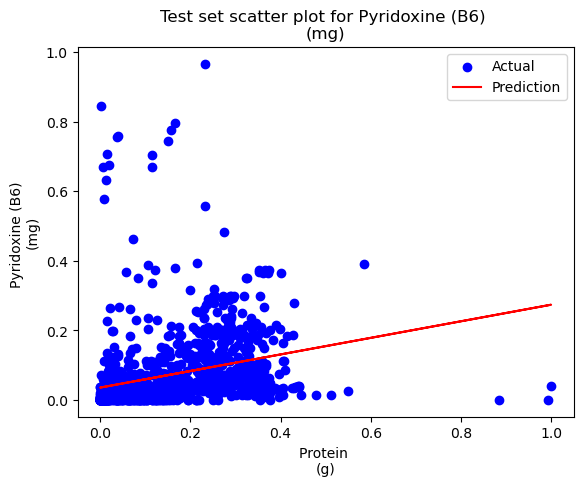

MSE of the linear model trained only by the feature: Protein (g): 0.010084874978064347


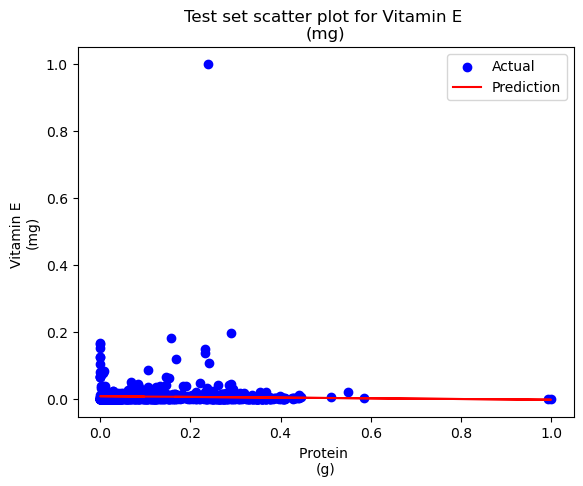

MSE of the linear model trained only by the feature: Protein (g): 0.0010343285132055579


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Read the Excel file (aka. sp|readsheet)
file_path = 'nutrient-file-release2-jan22.xlsx'
# The table is in the sheet: 'All solids & liquids per 100g'
data = pd.read_excel(file_path, sheet_name='All solids & liquids per 100g')

# only wants data after the third column because the first three columns are not nutrients
data = data.iloc[:, 3:]

# drop the column 'Protein \n(g)' because it is the topic we want to study
# data = data.drop(columns=['Protein \n(g)'])

# calculate the missing value ratio
missing_ratios = data.isnull().sum() / len(data)

# calculate the zero value ratio
zero_ratios = (data == 0).sum() / len(data)


# score
scores = pd.Series(0, index=data.columns)



# Calculate scores for the current nutrient
for column in data.columns:
    # 1. missing value ratio
    # for missing values: ==0% + 6, <1.0% + 5.85, <2.0% + 5.55, <5% + 5.15, <10% + 4.15, <20% + 2.15, other no score bonus
    if missing_ratios[column] == 0:
        scores[column] += 6.00
    elif 0 < missing_ratios[column] < 0.01:
        scores[column] += 5.85
    elif 0.01 < missing_ratios[column] < 0.02:
        scores[column] += 5.55
    elif 0.02 < missing_ratios[column] < 0.05:
        scores[column] += 5.15
    elif 0.05 < missing_ratios[column] < 0.1:
        scores[column] += 4.15
    elif 0.1 < missing_ratios[column] < 0.2:
        scores[column] += 2.15

    # 2. zero ratio
    # for zero values: <40% + 1.6, <30% + 2.4, <20% + 3.2, <10% + 3.6, <5% + 3.84, <2% + 3.92, =0 + 4 other no score bonus
    if 0.3 <= zero_ratios[column] < 0.4:
        scores[column] += 1.60
    elif 0.2 <= zero_ratios[column] < 0.3:
        scores[column] += 2.40
    elif 0.1 <= zero_ratios[column] < 0.2:
        scores[column] += 3.20
    elif 0.05 <= zero_ratios[column] < 0.1:
        scores[column] += 3.60
    elif 0.02 <= zero_ratios[column] < 0.05:
        scores[column] += 3.84
    elif 0.0 < zero_ratios[column] < 0.02:
        scores[column] += 3.92
    elif zero_ratios[column] == 0:
        scores[column] += 4.00

# get scores
scores = scores[scores > 9].sort_values(ascending=False)
print(scores)

# select the data with these high scores
data = data[scores.index]

# Initialize a MinMaxScaler, because out of all kinds of stardardizations, MinMaxScaler(aka normalization) is the most suitable for this data as for example the nutrient some of it is mg, some is g, and some g is very spread out some is very concentrated
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame so taht it's easier to work with and plot
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Compute the correlation matrix
corr_scaled = data_scaled.corr()

# Compute the correlation with 'Protein \n(g)'
protein_corr_scaled = corr_scaled['Protein \n(g)']

# Plot the correlation as a bar plot
plt.figure(figsize=(10, 5))
protein_corr_scaled[scores.index].sort_values().plot(kind='barh')
plt.title('Correlation with Protein (Scaled Data)', fontsize=20)
plt.xlabel('Correlation')
plt.show()

# Number of columns for subplot
n_cols = 2
# Calculate the number of rows needed for subplot, (len(scores.index ....) because we need the graph to be plot on the same row)
n_rows = len(scores.index) // n_cols + (len(scores.index) % n_cols > 0)

# Create empty subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows))

# Flatten the array of axes as it is a list of nutrients
axs = axs.flatten()

for nutrient, column in enumerate(scores.index):
    # Create a scatter plot for the scaled data
    axs[nutrient].scatter(data_scaled['Protein \n(g)'], data_scaled[column], s = 10)
    axs[nutrient].set_title(column)
    axs[nutrient].set_xlabel('Protein \n(g)')
    axs[nutrient].set_ylabel(column)
# Plot scatter plots
plt.tight_layout()
plt.show()

# Only the protein data, only create a new dataframe with the protein and currewnt nutrient column
protein_data = data_scaled[['Protein \n(g)']]

# Loop through each nutrient to fit a linear regression model
for column in data_scaled.columns:
    # Skip 'Protein \n(g)' itself
    if column == 'Protein \n(g)':
        continue

    # the current nutrient data
    nutrient_data = data_scaled[column].dropna()

    # Combine protein and current nutrient data
    combined_data = pd.concat([protein_data, nutrient_data], axis=1)

    # Split the data into training and testing data, test size 80%, training 20%
    train_data, test_data = train_test_split(combined_data, test_size=0.8)

    # Define the training data
    X_train = train_data[['Protein \n(g)']]
    y_train = train_data[column]

    # Define the testing data
    X_test = test_data[['Protein \n(g)']]
    y_test = test_data[column]

    # Fit the model to the training data
    model = LinearRegression().fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Plot the scatter plot and the line of regression (MSE)
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.plot(X_test, predictions, color='red', label='Prediction')
    plt.xlabel('Protein \n(g)')
    plt.ylabel(column)
    plt.title(f'Test set scatter plot for {column}')
    plt.legend()
    plt.show()

    # Print the result
    print('MSE of the linear model trained only by the feature: Protein (g):', mean_squared_error(y_test, predictions))


